In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm


## 1. Load Datasets

In [2]:
# main train and test datasets
columns = ['user_id', 'item_id', 'rating', 'timestamp']
train_df = pd.read_csv('data/ua.train', sep='\t', names=columns)
test_df = pd.read_csv('data/ua.test', sep='\t', names=columns)

# item information
item_columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url'] + [f'genre_{i}' for i in range(19)]
items_df = pd.read_csv('data/u.item', sep='|', names=item_columns, encoding='latin-1')

# genre names for readability
genres_df = pd.read_csv('data/u.genre', sep='|', names=['genre', 'genre_id'])
genre_mapping = dict(zip(genres_df['genre_id'], genres_df['genre']))

for i in range(len(genres_df)):
    old_name = f'genre_{i}'
    new_name = genre_mapping[i]
    items_df = items_df.rename(columns={old_name: new_name})
    
    
# user information
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_df = pd.read_csv('data/u.user', sep='|', names=user_columns)

# combine dataframes
train_df = train_df.merge(items_df, left_on='item_id', right_on='movie_id')
train_df = train_df.merge(users_df, on='user_id')

test_df = test_df.merge(items_df, left_on='item_id', right_on='movie_id')
test_df = test_df.merge(users_df, on='user_id')

In [3]:
items_df.head(15)

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
print(train_df.shape)
print(test_df.shape)

(90570, 32)
(9430, 32)


In [5]:
train_df.head(15)

,user_id,item_id,rating,timestamp,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip_code
0,1,1,5,874965758,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,...,0,0,0,0,0,0,24,M,technician,85711
1,1,2,3,876893171,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,...,0,0,0,1,0,0,24,M,technician,85711
2,1,3,4,878542960,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,...,0,0,0,1,0,0,24,M,technician,85711
3,1,4,3,876893119,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,...,0,0,0,0,0,0,24,M,technician,85711
4,1,5,3,889751712,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,...,0,0,0,1,0,0,24,M,technician,85711
5,1,6,5,887431973,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,...,0,0,0,0,0,0,24,M,technician,85711
6,1,7,4,875071561,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,...,0,0,1,0,0,0,24,M,technician,85711
7,1,8,1,875072484,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,...,0,0,0,0,0,0,24,M,technician,85711
8,1,9,5,878543541,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,...,0,0,0,0,0,0,24,M,technician,85711
9,1,10,3,875693118,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,...,0,0,0,0,1,0,24,M,technician,85711


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90570 entries, 0 to 90569
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             90570 non-null  int64  
 1   item_id             90570 non-null  int64  
 2   rating              90570 non-null  int64  
 3   timestamp           90570 non-null  int64  
 4   movie_id            90570 non-null  int64  
 5   movie_title         90570 non-null  object 
 6   release_date        90562 non-null  object 
 7   video_release_date  0 non-null      float64
 8   imdb_url            90558 non-null  object 
 9   unknown             90570 non-null  int64  
 10  Action              90570 non-null  int64  
 11  Adventure           90570 non-null  int64  
 12  Animation           90570 non-null  int64  
 13  Children's          90570 non-null  int64  
 14  Comedy              90570 non-null  int64  
 15  Crime               90570 non-null  int64  
 16  Docu

## 2. Data cleaning

In [7]:
train_df.describe()

,user_id,item_id,rating,timestamp,movie_id,video_release_date,unknown,Action,Adventure,Animation,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age
count,90570.000000,90570.000000,90570.000000,9.057000e+04,90570.000000,0.0,90570.000000,90570.000000,90570.000000,90570.000000,...,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000
mean,461.494038,428.104891,3.523827,8.835073e+08,428.104891,NaN,0.000099,0.255316,0.138103,0.036745,...,0.017423,0.053450,0.050348,0.051187,0.193364,0.126830,0.216054,0.093508,0.019079,32.857182
std,266.004364,333.088029,1.126073,5.341684e+06,333.088029,NaN,0.009968,0.436041,0.345010,0.188136,...,0.130842,0.224931,0.218663,0.220380,0.394938,0.332784,0.411554,0.291144,0.136804,11.489888
min,1.000000,1.000000,1.000000,8.747247e+08,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
25%,256.000000,174.000000,3.000000,8.794484e+08,174.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000
50%,442.000000,324.000000,4.000000,8.828143e+08,324.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000
75%,682.000000,636.000000,4.000000,8.882049e+08,636.000000,NaN,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000
max,943.000000,1682.000000,5.000000,8.932866e+08,1682.000000,NaN,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,73.000000


In [8]:
numeric_columns = train_df.select_dtypes(include=['number']).columns
correlation = train_df[numeric_columns].corr()
correlation_styled = correlation.style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).format("{:.2f}")
correlation_styled

,user_id,item_id,rating,timestamp,movie_id,video_release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age
user_id,1.00,0.01,-0.01,0.02,0.01,nan,-0.01,0.02,0.02,0.01,0.01,-0.01,-0.00,-0.01,-0.00,0.00,0.00,-0.01,0.00,0.01,0.01,0.01,0.00,0.01,0.00,-0.08
item_id,0.01,1.00,-0.19,0.04,1.00,nan,-0.00,-0.15,-0.08,-0.03,-0.01,0.02,-0.10,0.06,0.01,0.04,0.02,-0.01,-0.02,0.01,-0.01,-0.17,-0.05,-0.11,-0.02,-0.01
rating,-0.01,-0.19,1.00,-0.01,-0.19,nan,-0.00,-0.03,-0.01,0.01,-0.04,-0.08,0.03,0.01,0.11,-0.03,0.05,-0.05,0.00,0.02,0.04,0.01,-0.01,0.08,0.01,0.06
timestamp,0.02,0.04,-0.01,1.00,0.04,nan,-0.01,-0.01,-0.02,-0.02,-0.01,-0.02,0.00,0.00,0.03,-0.01,0.01,0.00,-0.00,0.03,0.01,-0.02,-0.00,-0.00,0.00,0.16
movie_id,0.01,1.00,-0.19,0.04,1.00,nan,-0.00,-0.15,-0.08,-0.03,-0.01,0.02,-0.10,0.06,0.01,0.04,0.02,-0.01,-0.02,0.01,-0.01,-0.17,-0.05,-0.11,-0.02,-0.01
video_release_date,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
unknown,-0.01,-0.00,-0.00,-0.01,-0.00,nan,1.00,-0.01,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.01
Action,0.02,-0.15,-0.03,-0.01,-0.15,nan,-0.01,1.00,0.45,-0.10,-0.14,-0.22,0.01,-0.05,-0.27,-0.01,-0.08,-0.01,-0.09,-0.03,-0.02,0.32,0.25,0.16,0.06,-0.07
Adventure,0.02,-0.08,-0.01,-0.02,-0.08,nan,-0.00,0.45,1.00,-0.02,0.10,-0.11,-0.03,-0.03,-0.22,0.09,-0.05,-0.06,-0.03,-0.04,-0.02,0.29,-0.05,0.08,0.01,-0.03
Animation,0.01,-0.03,0.01,-0.02,-0.03,nan,-0.00,-0.10,-0.02,1.00,0.56,0.03,-0.06,-0.02,-0.16,0.03,-0.03,-0.03,0.42,-0.05,-0.09,-0.04,-0.08,-0.06,-0.03,-0.03


### Drop uncessary features

Drop item_id since it's perfectly correlated to movie_id;

Drop timestamp since it's not interpretable;

Drop user_id, movie_id, imdb_url since they are not useful in classifying like/dislike;

Drop video_release_date since it's null;

Drop zipcode since it's hard to manipulate and is unlikely to affect movie rating;

Drop unknown since it has no variance.

In [9]:
train_df.drop(['user_id','timestamp','item_id', 'movie_id', 'video_release_date','unknown','imdb_url','zip_code'], axis=1, inplace=True)
test_df.drop(['user_id','timestamp','item_id','movie_id','video_release_date','unknown','imdb_url','zip_code'], axis=1, inplace=True)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90570 entries, 0 to 90569
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rating        90570 non-null  int64 
 1   movie_title   90570 non-null  object
 2   release_date  90562 non-null  object
 3   Action        90570 non-null  int64 
 4   Adventure     90570 non-null  int64 
 5   Animation     90570 non-null  int64 
 6   Children's    90570 non-null  int64 
 7   Comedy        90570 non-null  int64 
 8   Crime         90570 non-null  int64 
 9   Documentary   90570 non-null  int64 
 10  Drama         90570 non-null  int64 
 11  Fantasy       90570 non-null  int64 
 12  Film-Noir     90570 non-null  int64 
 13  Horror        90570 non-null  int64 
 14  Musical       90570 non-null  int64 
 15  Mystery       90570 non-null  int64 
 16  Romance       90570 non-null  int64 
 17  Sci-Fi        90570 non-null  int64 
 18  Thriller      90570 non-null  int64 
 19  War 

## 3. Feature engineering

Here are all feature engineering methods: <br><br>
1. Feature Removal
- Eliminated redundant identifiers (item_id, movie_id, user_id)
- Removed non-informative columns (timestamp, imdb_url, video_release_date)
- Dropped low-variance features (unknown column)
- Excluded difficult-to-process features (zip_code)
2. Data Transformation
- Converted release_date to numerical year format (day of week, release year, etc.)
- Created binary target variable (1 for ratings ≥ 4, 0 otherwise)
- One-hot encoded categorical variables (gender, occupation)
- Standardised all numerical features (age)
3. Data Quality Checks
- Merged movie and user information with ratings data
- Ensured no missing values or extreme outliers in final dataset


In [11]:
# like & dislike (binary target variable)
train_df['like_dislike'] = train_df['rating'].apply(lambda x: 1 if x >= 4 else 0)
test_df['like_dislike'] = test_df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# one-hot encoding 'gender', 'occupation'
train_df = pd.get_dummies(train_df, columns=['gender', 'occupation'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['gender', 'occupation'], drop_first=True)

# convert release date to datetime
train_df['release_date'] = pd.to_datetime(train_df['release_date'], format='%d-%b-%Y', errors='coerce')
train_df['release_year'] = 1998 - train_df['release_date'].dt.year

test_df['release_date'] = pd.to_datetime(test_df['release_date'], format='%d-%b-%Y', errors='coerce')
test_df['release_year'] = 1998 - test_df['release_date'].dt.year

# standardise user age
scaler_age = StandardScaler()

train_df['age'] = scaler_age.fit_transform(train_df[['age']])
test_df['age'] = scaler_age.transform(test_df[['age']]) 

import pandas as pd

# Calculate average rating per movie
# popularity = train_df.groupby('movie_title')['rating'].mean()

# Merge the average rating (popularity) back to the original DataFrame
# train_df = train_df.merge(popularity.rename('popularity'), on='movie_title', how='left')
# test_df = test_df.merge(popularity.rename('popularity'), on='movie_title', how='left')


In [12]:
train_df.head(15)

,rating,movie_title,release_date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,release_year
0,5,Toy Story (1995),1995-01-01,0,0,1,1,1,0,0,...,False,False,False,False,False,False,False,True,False,3.0
1,3,GoldenEye (1995),1995-01-01,1,1,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,3.0
2,4,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,3.0
3,3,Get Shorty (1995),1995-01-01,1,0,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,3.0
4,3,Copycat (1995),1995-01-01,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,True,False,3.0
5,5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,1995-01-01,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,3.0
6,4,Twelve Monkeys (1995),1995-01-01,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,3.0
7,1,Babe (1995),1995-01-01,0,0,0,1,1,0,0,...,False,False,False,False,False,False,False,True,False,3.0
8,5,Dead Man Walking (1995),1995-01-01,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,3.0
9,3,Richard III (1995),1996-01-22,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,2.0


In [13]:
train_df.head()

,rating,movie_title,release_date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,release_year
0,5,Toy Story (1995),1995-01-01,0,0,1,1,1,0,0,...,False,False,False,False,False,False,False,True,False,3.0
1,3,GoldenEye (1995),1995-01-01,1,1,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,3.0
2,4,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,3.0
3,3,Get Shorty (1995),1995-01-01,1,0,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,3.0
4,3,Copycat (1995),1995-01-01,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,True,False,3.0


In [14]:
train_df.drop(['rating','release_date','movie_title'], axis=1, inplace=True)
test_df.drop(['rating','release_date','movie_title'], axis=1, inplace=True)

In [15]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90562 entries, 0 to 90569
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Action                    90562 non-null  int64  
 1   Adventure                 90562 non-null  int64  
 2   Animation                 90562 non-null  int64  
 3   Children's                90562 non-null  int64  
 4   Comedy                    90562 non-null  int64  
 5   Crime                     90562 non-null  int64  
 6   Documentary               90562 non-null  int64  
 7   Drama                     90562 non-null  int64  
 8   Fantasy                   90562 non-null  int64  
 9   Film-Noir                 90562 non-null  int64  
 10  Horror                    90562 non-null  int64  
 11  Musical                   90562 non-null  int64  
 12  Mystery                   90562 non-null  int64  
 13  Romance                   90562 non-null  int64  
 14  Sci-Fi     

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9429 entries, 0 to 9429
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Action                    9429 non-null   int64  
 1   Adventure                 9429 non-null   int64  
 2   Animation                 9429 non-null   int64  
 3   Children's                9429 non-null   int64  
 4   Comedy                    9429 non-null   int64  
 5   Crime                     9429 non-null   int64  
 6   Documentary               9429 non-null   int64  
 7   Drama                     9429 non-null   int64  
 8   Fantasy                   9429 non-null   int64  
 9   Film-Noir                 9429 non-null   int64  
 10  Horror                    9429 non-null   int64  
 11  Musical                   9429 non-null   int64  
 12  Mystery                   9429 non-null   int64  
 13  Romance                   9429 non-null   int64  
 14  Sci-Fi       

In [18]:
train_df.describe()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,like_dislike,release_year
count,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,...,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000
mean,0.255339,0.138115,0.036748,0.072525,0.300093,0.080155,0.007575,0.397639,0.013736,0.017425,...,0.050352,0.051191,0.193381,0.126841,0.216073,0.093516,0.019081,0.000051,0.551026,10.234767
std,0.436054,0.345023,0.188144,0.259356,0.458301,0.271535,0.086704,0.489413,0.116395,0.130848,...,0.218672,0.220389,0.394952,0.332797,0.411567,0.291156,0.136810,1.000027,0.497392,14.250570
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.250442,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.770872,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.248671,1.000000,4.000000
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.621665,1.000000,12.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.493771,1.000000,76.000000


In [19]:
train_df.head(15)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,release_year
0,0,0,1,1,1,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,3.0
1,1,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,3.0
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,3.0
3,1,0,0,0,1,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,3.0
4,0,0,0,0,0,1,0,1,0,0,...,False,False,False,False,False,False,False,True,False,3.0
5,0,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,3.0
6,0,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,3.0
7,0,0,0,1,1,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,3.0
8,0,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,3.0
9,0,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,2.0


In [20]:
train_df.columns

Index(['Action', 'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
       'like_dislike', 'gender_M', 'occupation_artist', 'occupation_doctor',
       'occupation_educator', 'occupation_engineer',
       'occupation_entertainment', 'occupation_executive',
       'occupation_healthcare', 'occupation_homemaker', 'occupation_lawyer',
       'occupation_librarian', 'occupation_marketing', 'occupation_none',
       'occupation_other', 'occupation_programmer', 'occupation_retired',
       'occupation_salesman', 'occupation_scientist', 'occupation_student',
       'occupation_technician', 'occupation_writer', 'release_year'],
      dtype='object')

## 4. Neural Network Architecture and Training Pipeline

### Model Architecture: Multi-Layer Perceptron (MLP)

The model implements a flexible Multi-Layer Perceptron with configurable hidden layers and dropout regularization (for later hyperparameter tuning):

#### Network Structure
- **Input Layer**: Accepts `num_features` dimensional input
- **Hidden Layers**: Configurable through `hidden_layers` parameter
  - Default configuration: `[512, 256]` units
  - Each hidden layer includes:
    - Linear transformation
    - ReLU activation
    - Dropout (rate = 0.5)
- **Output Layer**: Single unit with linear activation (for binary classification)

#### Key Features
- Dropout rate for regularization (configurable)
- Modular design allowing easy modification of layer sizes

#### Training Configuration
- Implements seed-based reproducibility
- Uses adaptive learning rate optimizer (to be specified)
- Binary cross-entropy loss (implied by architecture)
- Progress tracking with tqdm progress bars
  
#### Metrics Tracked
- Training loss (averaged per epoch)
- Validation loss
- Validation accuracy percentage
- All metrics are stored in lists for later analysis

In [21]:
class MLP(nn.Module):
    def __init__(self, num_features, hidden_layers=[512, 256], dropout_rate=0.5):
        super(MLP, self).__init__()
        
        layers = []
        prev_size = num_features
        
        for hidden_size in hidden_layers:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        return self.classifier(x)

def train_validate_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, seed=0):
    np.random.seed(seed)
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # create outer progress bar for epochs
    epoch_pbar = tqdm(range(epochs), desc='Epochs')
    
    for epoch in epoch_pbar:
        # training phase
        model.train()
        train_loss = 0.0
        
        # create inner progress bar for training batches
        train_pbar = tqdm(train_loader, desc=f'Training', leave=False)
        
        for inputs, labels in train_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        # validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Validation', leave=False)
            
            for inputs, labels in val_pbar:
                inputs = inputs.to(device)
                labels = labels.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), labels)
                val_loss += loss.item()
                
                # calculate accuracy
                predicted = (outputs.view(-1) > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # calculate average losses and accuracy
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # update progress bar description with current metrics
        epoch_pbar.set_postfix({
            'train_loss': f'{avg_train_loss:.4f}',
            'val_loss': f'{avg_val_loss:.4f}',
            'val_acc': f'{val_accuracy:.2f}%'
        })
    
    return train_losses, val_losses, val_accuracies

## Metrics
Here, we will be evaluating certain metrics:
- Base: Precision, Recall, F1-Score, Accuracy
- ROC-AUC
- Youden's Index
- Cumulative lift

In [86]:
def calculate_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    # collect predictions and labels
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            # ensure we're getting flat arrays
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.numpy().flatten())
            all_probs.extend(probs.cpu().numpy().flatten())
    
    # convert to numpy arrays and ensure they're 1D
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    all_probs = np.array(all_probs).flatten()
    
    # get basic classification metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    # calculate roc and find optimal threshold
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # get youden's index (tpr - fpr) and corresponding threshold
    youden_indices = tpr - fpr
    optimal_idx = np.argmax(youden_indices)
    youden_index = youden_indices[optimal_idx]
    optimal_threshold = thresholds[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]
    
    # sort by predicted probabilities for lift calculation
    sorted_indices = np.argsort(all_probs)[::-1]  # sort in descending order
    sorted_probs = all_probs[sorted_indices]
    sorted_labels = all_labels[sorted_indices]
    
    # just some simple debuggs hahah
    print("\nSorting check:")
    print(f"sorted_probs first 5: {sorted_probs[:5]}")
    print(f"sorted_probs last 5: {sorted_probs[-5:]}")
    
    # get baseline response rate
    baseline_rate = np.mean(all_labels)
    print(f"\nbaseline rate: {baseline_rate:.4f}")
    
    # calculate metrics for each decile
    n_samples = len(sorted_labels)
    decile_size = n_samples // 10
    
    lift_values = []
    cumulative_lifts = []
    decile_response_rates = []
    
    total_positives = 0
    
    for i in range(10):
        start_idx = i * decile_size
        end_idx = start_idx + decile_size if i < 9 else n_samples
        
        # get labels for current decile
        decile_labels = sorted_labels[start_idx:end_idx]
        decile_positives = np.sum(decile_labels)
        total_positives += decile_positives
        
        # calculate response rate for this decile
        decile_response_rate = np.mean(decile_labels)
        decile_response_rates.append(decile_response_rate)
        
        # calculate lift for this decile
        decile_lift = decile_response_rate / baseline_rate if baseline_rate > 0 else 0
        lift_values.append(decile_lift)
        
        # calculate cumulative lift up to this decile
        expected_positives = baseline_rate * (end_idx - 0)
        cumulative_lift = (total_positives / expected_positives) if expected_positives > 0 else 0
        cumulative_lifts.append(cumulative_lift)
    
    percentiles = np.arange(10, 101, 10)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'youden_index': youden_index,
        'optimal_threshold': optimal_threshold,
        'optimal_fpr': optimal_fpr,
        'optimal_tpr': optimal_tpr,
        'fpr': fpr,
        'tpr': tpr,
        'cumulative_lifts': cumulative_lifts,
        'percentiles': percentiles,
        'lift_values': lift_values,
        'decile_response_rates': decile_response_rates,
        'average_response_rate': baseline_rate
    }

# plot and print_lift_details functions remain the same
def plot_cumulative_lift(percentiles, cumulative_lifts, lift_values):
    plt.figure(figsize=(10, 6))
    
    # plot both lift curves
    plt.plot(percentiles, cumulative_lifts, 'b-', lw=2, marker='o', label='cumulative lift')
    plt.plot(percentiles, lift_values, 'g--', lw=2, marker='s', label='decile lift')
    
    # add reference line
    plt.axhline(y=1, color='r', linestyle='--', label='baseline')
    
    plt.xlabel('population percentage')
    plt.ylabel('lift')
    plt.title('lift chart')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def print_lift_details(metrics):
    print("\nlift analysis by decile:")
    print("decile | resp rate | lift | cum lift")
    print("-" * 45)
    
    for i, (rr, l, cl) in enumerate(zip(
        metrics['decile_response_rates'],
        metrics['lift_values'],
        metrics['cumulative_lifts']
    )):
        print(f"{i+1:>6} | {rr:>9.4f} | {l:>4.2f}x | {cl:>8.2f}x")
    
    print(f"\nbaseline response rate: {metrics['average_response_rate']:.4f}")

## Hyperparameter tuning
We will be employing 5-fold cross validation when selecting the hyperparameters, which is then trained on the entire u.data before predicting on the test set. <br>
Since we are using a custom neural network model, we will have to implement our own cross-fold validation with the function below

In [23]:
def grid_search_cv(X, y, num_features, param_grid, device='cuda', k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=0) # k-fold cross-validation
    
    param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
    
    best_params = None
    best_score = float('-inf')
    results = []
    
    for params in param_combinations:
        fold_scores = []
        
        print(f"testing parameters: {params}")
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            # create data loaders for this fold
            train_data = TensorDataset(
                torch.FloatTensor(X[train_idx]), 
                torch.FloatTensor(y[train_idx])
            )
            val_data = TensorDataset(
                torch.FloatTensor(X[val_idx]), 
                torch.FloatTensor(y[val_idx])
            )
            
            train_loader = DataLoader(
                train_data,
                batch_size=params['batch_size'],
                shuffle=True
            )
            val_loader = DataLoader(
                val_data,
                batch_size=params['batch_size']
            )
            
            model = MLP(
                num_features=num_features,
                hidden_layers=params['hidden_layers'],
                dropout_rate=params['dropout_rate']
            ).to(device)
            
            if params['optimizer'] == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=params['l_rate'])
            elif params['optimizer'] == 'AdamW':
                optimizer = torch.optim.AdamW(model.parameters(), lr=params['l_rate'])
            else:  # SGD
                optimizer = torch.optim.SGD(model.parameters(), lr=params['l_rate'])
            
            criterion = nn.BCEWithLogitsLoss()
            
            train_validate_model(
                model, train_loader, val_loader,
                criterion, optimizer, device,
                params['n_epochs']
            )
            
            # evaluate model
            metrics = calculate_metrics(model, val_loader, device)
            fold_scores.append(metrics['f1'])
        
        avg_score = np.mean(fold_scores)
        print(f'average f1-score: {avg_score}')
        results.append({
            'params': params,
            'score': avg_score
        })
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = params
    
    return best_params, results

In [24]:
def prepare_data(train_df, test_df):
    # convert boolean columns to int8
    bool_columns = train_df.select_dtypes(include=['bool']).columns
    train_df[bool_columns] = train_df[bool_columns].astype('int8')
    test_df[bool_columns] = test_df[bool_columns].astype('int8')
    
    # convert dataframes to numpy arrays and ensure correct shapes
    X_train = train_df.drop(columns=['like_dislike']).values.astype(np.float32)
    y_train = train_df['like_dislike'].values.astype(np.float32)
    
    X_test = test_df.drop(columns=['like_dislike']).values.astype(np.float32)
    y_test = test_df['like_dislike'].values.astype(np.float32)
    
    return X_train, y_train, X_test, y_test

In [28]:
# set up hyperparameter grid
param_grid = {
    'l_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64],
    'hidden_layers': [[256, 128], [512, 256, 128], [1024, 512, 256]],
    'optimizer': ['Adam', 'SGD'],
    'dropout_rate': [0.0, 0.25, 0.5],
    'n_epochs': [10, 20]
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

# prepare the data
X_train, y_train, X_test, y_test = prepare_data(train_df, test_df)

num_features = X_train.shape[1]

using device: cuda


In [ ]:
# run grid search with cross validation
best_params, results = grid_search_cv(
    X_train, 
    y_train, 
    num_features=num_features,
    param_grid=param_grid,
    device=device
)

print("\nbest parameters found:")
print(best_params)

using device: cuda
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.0, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [00:58<00:00,  5.82s/it, train_loss=0.6118, val_loss=0.6354, val_acc=61.60%]


average accuracy: 0.7051971661175818
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.0, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [02:06<00:00,  6.33s/it, train_loss=0.5881, val_loss=0.6443, val_acc=60.86%]


average accuracy: 0.6957282602926987
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.25, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [01:03<00:00,  6.37s/it, train_loss=0.6275, val_loss=0.6328, val_acc=61.28%]


average accuracy: 0.7079804887734179
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.25, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [02:12<00:00,  6.62s/it, train_loss=0.6173, val_loss=0.6313, val_acc=59.89%]


average accuracy: 0.7042194987908418
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.5, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [01:05<00:00,  6.56s/it, train_loss=0.6400, val_loss=0.6365, val_acc=58.65%]


average accuracy: 0.7057443976861942
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.5, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [02:12<00:00,  6.61s/it, train_loss=0.6308, val_loss=0.6332, val_acc=59.00%]


average accuracy: 0.7120827949160085
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'SGD', 'dropout_rate': 0.0, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [00:43<00:00,  4.38s/it, train_loss=0.6690, val_loss=0.6693, val_acc=52.24%]


average accuracy: 0.6816870270984359
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'SGD', 'dropout_rate': 0.0, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [01:28<00:00,  4.41s/it, train_loss=0.6620, val_loss=0.6622, val_acc=53.78%]


average accuracy: 0.6743353091428571
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'SGD', 'dropout_rate': 0.25, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [00:46<00:00,  4.62s/it, train_loss=0.6753, val_loss=0.6748, val_acc=51.05%]


average accuracy: 0.6965407317951936
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'SGD', 'dropout_rate': 0.25, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [01:32<00:00,  4.62s/it, train_loss=0.6731, val_loss=0.6727, val_acc=52.08%]


average accuracy: 0.6858450301264998
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'SGD', 'dropout_rate': 0.5, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [00:46<00:00,  4.62s/it, train_loss=0.6766, val_loss=0.6782, val_acc=48.36%]


average accuracy: 0.7072160793846922
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'SGD', 'dropout_rate': 0.5, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [01:33<00:00,  4.66s/it, train_loss=0.6757, val_loss=0.6770, val_acc=49.01%]


average accuracy: 0.6992779248524436
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [512, 256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.0, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [01:04<00:00,  6.44s/it, train_loss=0.6068, val_loss=0.6380, val_acc=62.03%]


average accuracy: 0.7083736684249001
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [512, 256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.0, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it, train_loss=0.5736, val_loss=0.6676, val_acc=62.20%]


average accuracy: 0.6970819272506005
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [512, 256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.25, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [01:08<00:00,  6.86s/it, train_loss=0.6252, val_loss=0.6319, val_acc=60.25%]


average accuracy: 0.6995412995953652
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [512, 256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.25, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [02:23<00:00,  7.19s/it, train_loss=0.6105, val_loss=0.6374, val_acc=62.78%]


average accuracy: 0.7101273734813491
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [512, 256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.5, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [01:10<00:00,  7.07s/it, train_loss=0.6405, val_loss=0.6382, val_acc=58.96%]


average accuracy: 0.7018457131289965
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [512, 256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.5, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [02:36<00:00,  7.80s/it, train_loss=0.6321, val_loss=0.6374, val_acc=57.60%]


average accuracy: 0.7040398105705279
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [512, 256, 128], 'optimizer': 'SGD', 'dropout_rate': 0.0, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [00:46<00:00,  4.65s/it, train_loss=0.6729, val_loss=0.6735, val_acc=51.19%]


average accuracy: 0.6809010678919825
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [512, 256, 128], 'optimizer': 'SGD', 'dropout_rate': 0.0, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it, train_loss=0.6677, val_loss=0.6679, val_acc=52.37%]


average accuracy: 0.678846035833766
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [512, 256, 128], 'optimizer': 'SGD', 'dropout_rate': 0.25, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [00:54<00:00,  5.49s/it, train_loss=0.6755, val_loss=0.6752, val_acc=51.08%]


average accuracy: 0.7018637372128108
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [512, 256, 128], 'optimizer': 'SGD', 'dropout_rate': 0.25, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [02:09<00:00,  6.48s/it, train_loss=0.6743, val_loss=0.6736, val_acc=51.07%]


average accuracy: 0.6864324360964131
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [512, 256, 128], 'optimizer': 'SGD', 'dropout_rate': 0.5, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [01:09<00:00,  6.98s/it, train_loss=0.6777, val_loss=0.6797, val_acc=47.74%]


average accuracy: 0.7091266967000418
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [512, 256, 128], 'optimizer': 'SGD', 'dropout_rate': 0.5, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [01:43<00:00,  5.19s/it, train_loss=0.6768, val_loss=0.6804, val_acc=46.99%]


average accuracy: 0.705539897396333
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [1024, 512, 256], 'optimizer': 'Adam', 'dropout_rate': 0.0, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [01:30<00:00,  9.03s/it, train_loss=0.6045, val_loss=0.6424, val_acc=62.41%]


average accuracy: 0.7060039598868176
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [1024, 512, 256], 'optimizer': 'Adam', 'dropout_rate': 0.0, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [03:01<00:00,  9.06s/it, train_loss=0.5656, val_loss=0.6938, val_acc=62.41%]


average accuracy: 0.6998322982156193
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [1024, 512, 256], 'optimizer': 'Adam', 'dropout_rate': 0.25, 'n_epochs': 10}


Epochs: 100%|██████████| 10/10 [01:38<00:00,  9.89s/it, train_loss=0.6227, val_loss=0.6327, val_acc=59.82%]


average accuracy: 0.7071037812996803
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [1024, 512, 256], 'optimizer': 'Adam', 'dropout_rate': 0.25, 'n_epochs': 20}


Epochs: 100%|██████████| 20/20 [03:16<00:00,  9.83s/it, train_loss=0.6059, val_loss=0.6373, val_acc=61.85%]


average accuracy: 0.7089212270313967
testing parameters: {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [1024, 512, 256], 'optimizer': 'Adam', 'dropout_rate': 0.5, 'n_epochs': 10}


Epochs:  20%|██        | 2/10 [00:19<01:18,  9.84s/it, train_loss=0.6543, val_loss=0.6500, val_acc=59.73%]

We have ran the grid search cross-validation multiple times due to the high time complexity of the code, which is why not all results may be shown here. 
The set of best hyperparameters are:
- Learning rate: 0.001
- Batch size: 32
- Hidden layer size: [256, 128]
- Optimizer: Adam
- Dropout Rate: 0.5
- Number of Epochs: 20

** also do note that we are tuning for f1-score, not average accuracy

In [88]:
best_params = {'l_rate': 0.001, 'batch_size': 32, 'hidden_layers': [256, 128], 'optimizer': 'Adam', 'dropout_rate': 0.5, 'n_epochs': 20}

# train final model with best parameters
final_model = MLP(
    num_features=num_features,
    hidden_layers=best_params['hidden_layers'],
    dropout_rate=best_params['dropout_rate']
).to(device)

train_dataset = TensorDataset(
    torch.FloatTensor(X_train),
    torch.FloatTensor(y_train)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_test),
    torch.FloatTensor(y_test)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=best_params['batch_size'],
    shuffle=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=best_params['batch_size']
)

if best_params['optimizer'] == 'Adam': optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['l_rate'])
elif best_params['optimizer'] == 'AdamW': optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_params['l_rate'])
else: optimizer = torch.optim.SGD(final_model.parameters(), lr=best_params['l_rate'])

criterion = nn.BCEWithLogitsLoss()

train_losses, val_losses, val_accuracies = train_validate_model(
    final_model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    device,
    best_params['n_epochs']
)

Epochs: 100%|██████████| 20/20 [03:44<00:00, 11.23s/it, train_loss=0.6313, val_loss=0.6425, val_acc=55.07%]



Sorting check:
sorted_probs first 5: [0.9624789  0.9490652  0.9349196  0.92949533 0.9288819 ]
sorted_probs last 5: [0.08292319 0.06082507 0.05027115 0.04073721 0.02470215]

baseline rate: 0.5799

Final Model Metrics:
accuracy: 0.6335
precision: 0.6475
recall: 0.8078
f1: 0.7188
roc_auc: 0.6613
youden_index: 0.2419
optimal_threshold: 0.5526

Youden's Index Details:
Youden's index: 0.2419
Optimal threshold: 0.5526
At FPR: 0.4257, TPR: 0.6675


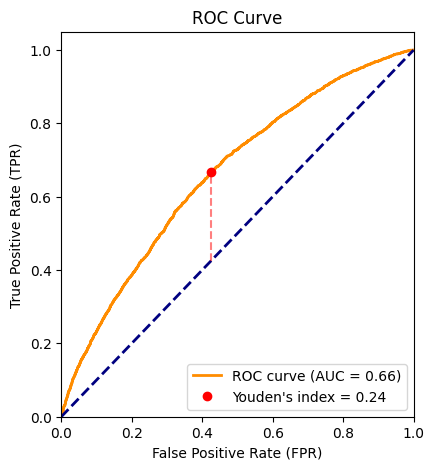

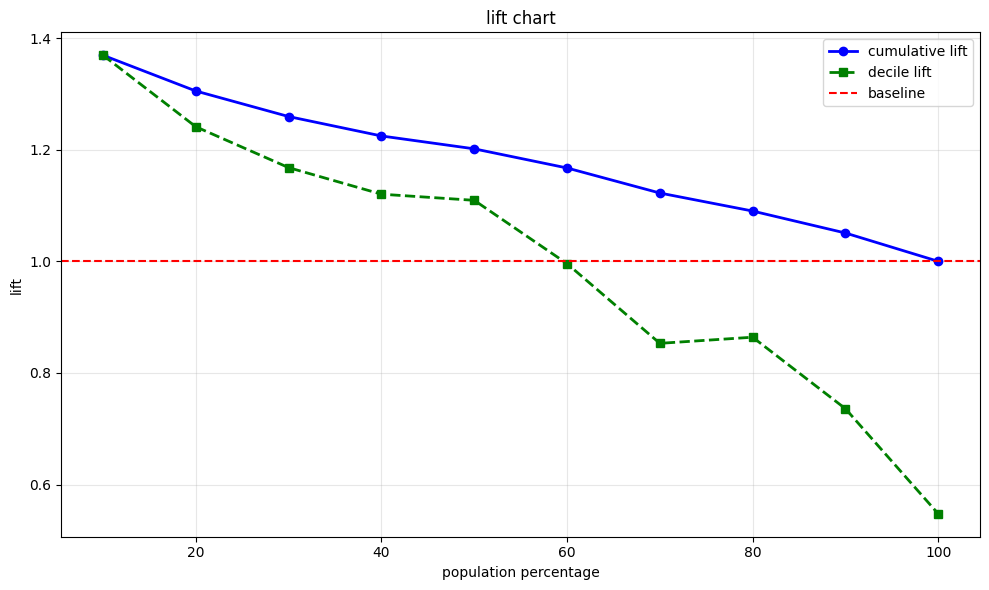


Lift Values:
Percentile  |  Cumulative Lift  |  Point Lift
---------------------------------------------
       10%  |            1.37x  |        1.37x
       20%  |            1.31x  |        1.24x
       30%  |            1.26x  |        1.17x
       40%  |            1.22x  |        1.12x
       50%  |            1.20x  |        1.11x
       60%  |            1.17x  |        1.00x
       70%  |            1.12x  |        0.85x
       80%  |            1.09x  |        0.86x
       90%  |            1.05x  |        0.74x
      100%  |            1.00x  |        0.55x


In [89]:
# plotting overall metrics
final_metrics = calculate_metrics(final_model, test_loader, device)
print("\nFinal Model Metrics:")
metrics_to_display = [
    'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 
    'youden_index', 'optimal_threshold'
]
for metric in metrics_to_display:
    print(f"{metric}: {final_metrics[metric]:.4f}")

# plot ROC curve with Youden's index point
plot_roc_curve(
    final_metrics['fpr'],
    final_metrics['tpr'],
    final_metrics['roc_auc'],
    final_metrics['optimal_fpr'],
    final_metrics['optimal_tpr'],
    final_metrics['youden_index']
)

# print Youden's index details
print(f"\nYouden's Index Details:")
print(f"Youden's index: {final_metrics['youden_index']:.4f}")
print(f"Optimal threshold: {final_metrics['optimal_threshold']:.4f}")
print(f"At FPR: {final_metrics['optimal_fpr']:.4f}, TPR: {final_metrics['optimal_tpr']:.4f}")

# plot cumulative lift
plot_cumulative_lift(
    final_metrics['percentiles'], 
    final_metrics['cumulative_lifts'],
    final_metrics['lift_values']
)

# print lift values
print("\nLift Values:")
print("Percentile  |  Cumulative Lift  |  Point Lift")
print("-" * 45)
for p, cl, l in zip(final_metrics['percentiles'], 
                    final_metrics['cumulative_lifts'], 
                    final_metrics['lift_values']):
    print(f"{p:>9}%  |  {cl:>14.2f}x  |  {l:>10.2f}x")